In [1]:
from dotenv import load_dotenv
load_dotenv() # OPENAI_API_KEY, PINECONE_API_KEY

True

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

llm = ChatOpenAI(model="gpt-4.1", temperature=0)
small_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = PineconeVectorStore(
    index_name="inhouse-python-index",
    embedding=embeddings,
)
retriever = vector_store.as_retriever()

/Users/jasonkang/inflearn/agent-use-cases/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langchain_core.documents import Document


class AgentState(TypedDict):
    question: str
    answer: str
    context: list[Document]
    document_name: str
    is_in_faq: bool
    
graph_builder = StateGraph(AgentState)

In [4]:
from langchain_core.prompts import ChatPromptTemplate 
from langchain_core.output_parsers import StrOutputParser


def check_faq(state: AgentState) -> AgentState:
    question = state['question']
    context = retriever.invoke(question, filter={"source": "employee_benefits_and_welfare_faq"})
    check_faq_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that checks if the question is in the FAQ. 
If the question is in the FAQ, return 'Yes'. Otherwise, return 'No'."""),
        ("user", "Question: {question}\nContext: {context}"),
    ])
    check_faq_chain = check_faq_prompt | llm | StrOutputParser()
    is_in_faq = check_faq_chain.invoke({"question": question, "context": context})
    return {"is_in_faq": is_in_faq == "Yes", "context": context if is_in_faq == "Yes" else []}

In [5]:
def get_document_name(state: AgentState) -> AgentState:
    determine_document_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """You are a helpful assistant that determines the most relevant document name based on the user's question. 
Choose from the following document names:
- delegation_of_authority
- employee_benefits_and_welfare_faq
- employee_benefits_and_welfare_guide
- employee_handbook_and_hr_policy
- expense_management_guide
- it_support_guide
- legal_and_compliance_policy

Return ONLY the document name (e.g., 'it_support_guide').

Examples:
- If the question is about who can approve expenses, return 'delegation_of_authority' or 'expense_management_guide' as appropriate.
- If the question is about employee benefits, return 'employee_benefits_and_welfare_guide'.
- If the question is about HR policies or the employee handbook, return 'employee_handbook_and_hr_policy'.
- If the question is about IT support or technical issues, return 'it_support_guide'.
- If the question is about legal or compliance matters, return 'legal_and_compliance_policy'.
- If the question is a frequently asked question about benefits, return 'employee_benefits_and_welfare_faq'.
"""),
        ("user", "Question: {question}"),
    ]
)
    question = state['question']
    determine_document_chain = determine_document_prompt | small_llm | StrOutputParser()
    document_name = determine_document_chain.invoke({"question": question})
    return {"document_name": document_name}

In [6]:
def retrieve_document(state: AgentState) -> AgentState:
    question = state['question']
    document_name = state['document_name']
    context = retriever.invoke(question, filter={"source": document_name})
    return {"context": context}

In [7]:
def generate_answer(state: AgentState) -> AgentState:
    question = state['question']
    context = state['context']
    generate_answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that generates an answer to the user's question based on the context.
        """),
        ("user", "Question: {question}\nContext: {context}"),
    ])
    generate_answer_chain = generate_answer_prompt | llm | StrOutputParser()
    answer = generate_answer_chain.invoke({"question": question, "context": context})
    return {"answer": answer}

In [8]:
from typing import Literal

def check_if_in_faq(state: AgentState) -> Literal["generate_answer", "get_document_name"]:
    is_in_faq = state['is_in_faq']
    if is_in_faq:
        return "generate_answer"
    else:
        return "get_document_name"

In [9]:
from langgraph.graph import START, END

graph_builder.add_node(check_faq)
graph_builder.add_node(get_document_name)
graph_builder.add_node(retrieve_document)
graph_builder.add_node(generate_answer)

graph_builder.add_edge(START, "check_faq")
graph_builder.add_conditional_edges("check_faq", check_if_in_faq)
graph_builder.add_edge("get_document_name", "retrieve_document")
graph_builder.add_edge("retrieve_document", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile()

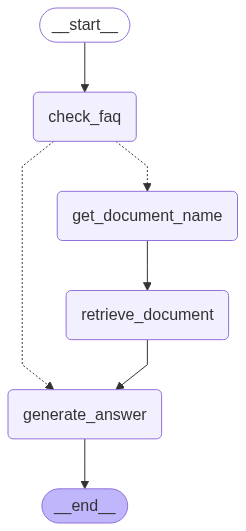

In [10]:
graph

In [11]:
graph.invoke({"question": "사내 네트워크 담당자는 누구인가요?"})

{'question': '사내 네트워크 담당자는 누구인가요?',
 'answer': '사내 네트워크 담당자는 김영수 (IT 네트워크 관리자)입니다.  \n이메일: kimys@company.com  \n전화번호: 02-1234-5680',
 'context': [Document(id='c4fc05d7-76c2-48e0-b51f-2c0aa8405ba3', metadata={'chapter': '제 1 장 IT 지원 기본 정책', 'section': '제 3 조 (IT 지원 담당자)', 'source': 'it_support_guide', 'title': 'IT 지원 가이드'}, page_content='- **네트워크 지원**\n- 담당자: 김영수 (IT 네트워크 관리자)\n- 이메일: kimys@company.com\n- 전화번호: 02-1234-5680\n- **계정관리 및 보안**\n- 담당자: 이민정 (보안 관리자)\n- 이메일: leemj@company.com\n- 전화번호: 02-1234-5681\n- **소프트웨어 및 시스템 유지보수**\n- 담당자: 박상호 (IT 시스템 관리자)\n- 이메일: parksh@company.com\n- 전화번호: 02-1234-5682  \n---'),
  Document(id='a413c123-ba06-4c91-bec2-3bcd96e8697e', metadata={'chapter': '제 3장 네트워크 및 VPN 접속', 'section': '제 6조 (사내 네트워크 접속)', 'source': 'it_support_guide', 'title': 'IT 지원 가이드'}, page_content='- 모든 사내 네트워크 접속은 인증된 사용자 계정으로만 가능하다.\n- 외부 접속 시 VPN 사용이 필수이다.\n- VPN 계정은 IT 지원팀을 통해 신청할 수 있다.'),
  Document(id='73334394-4602-4b4d-b57d-d4e16f376cc9', metadata={'chapter': '제 6장 데이터 보

In [14]:
graph.invoke({"question": "출산휴가는 얼마나 보장되나요?"})

{'question': '출산휴가는 얼마나 보장되나요?',
 'answer': '출산휴가는 출산 예정일 전후로 자유롭게 사용할 수 있으며, 최대 20일 유급으로 보장됩니다.',
 'context': [Document(id='824b9c66-269f-409d-b59f-9fcd389d75fb', metadata={'chapter': '2. 출산 및 육아 휴가 관련', 'section': 'Q4: 출산 휴가는 언제부터 사용할 수 있나요?', 'source': 'employee_benefits_and_welfare_faq', 'title': '직원 복리후생 및 복지 FAQ'}, page_content='- A: 출산 예정일 전후로 자유롭게 사용할 수 있으며, 최대 20일 유급으로 제공됩니다.'),
  Document(id='1036ec07-8314-47ef-97f1-2b74ef2cfd65', metadata={'chapter': '3. 경조 휴가 및 지원', 'section': 'Q6: 경조 휴가는 어떤 경우에 사용할 수 있나요?', 'source': 'employee_benefits_and_welfare_faq', 'title': '직원 복리후생 및 복지 FAQ'}, page_content='- A: 본인 결혼, 자녀 출생, 부모/배우자 사망 등 경조사 사유에 따라 휴가가 부여됩니다.'),
  Document(id='f0b7c834-5d42-42b5-8f47-3acb418c29ac', metadata={'chapter': '2. 출산 및 육아 휴가 관련', 'section': 'Q5: 육아 휴가는 누구에게 적용되나요?', 'source': 'employee_benefits_and_welfare_faq', 'title': '직원 복리후생 및 복지 FAQ'}, page_content='- A: 모든 직원이 신청할 수 있으며, 최대 1년까지 사용할 수 있으며, 첫 3개월은 급여의 50%가 지급됩니다.  \n---'),
  Document(id='1bd85b06-53b0-